In [1]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from numpy import asarray
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA

# Data Import and Cleaning

In [2]:
df = pd.read_excel("/Users/surajkwork/Documents/Thesis/thesis/df.xlsx")

The date variable is not in datetime format so it has to be converted.

In [3]:
df['date']= pd.to_datetime(df['date'])
df.index = df['date']
df.sort_index(inplace=True)

Extracting one cluster from the dataset for analysis.

In [4]:
TS1 = df[(df['Plz'] == "['25', '24']")]

And from this cluster, extracting one category for analysis.

In [5]:
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']

In [6]:
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

In [7]:
datasets = [TS1_A2, TS1_A1A2, TS1_A2A3]

In [8]:
nobs = 6
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]

## Decision Tree

In [9]:
from sklearn.tree import DecisionTreeRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [29]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from skforecast.model_selection import backtesting_forecaster
from skforecast.preprocessing import TimeSeriesDifferentiator
from sklearn.metrics import mean_absolute_error

In [31]:
data = TS1_A1A2['wPreis']
data

date
2020-09-14   -37.519318
2020-09-28   -28.690096
2020-10-12   -29.688079
2020-10-19   -25.630433
2020-10-26   -29.073794
                ...    
2023-08-07     7.832750
2023-08-14     3.525113
2023-08-21     3.896402
2023-08-28     6.754483
2023-09-04     2.053265
Name: wPreis, Length: 154, dtype: float64

In [32]:
diferenciator = TimeSeriesDifferentiator(order=1)
data_diff = diferenciator.fit_transform(data)
data_diff = pd.Series(data_diff, index=data.index).dropna()
data_diff.head(4)

date
2020-09-28    8.829222
2020-10-12   -0.997983
2020-10-19    4.057645
2020-10-26   -3.443361
dtype: float64

In [33]:
data_diff.shape

(153,)

In [37]:
end_train = '2023-07-31'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")



Train dates : 2020-09-14 00:00:00 --- 2023-07-31 00:00:00  (n=149)
Test dates  : 2023-07-31 00:00:00 --- 2023-09-04 00:00:00  (n=6)


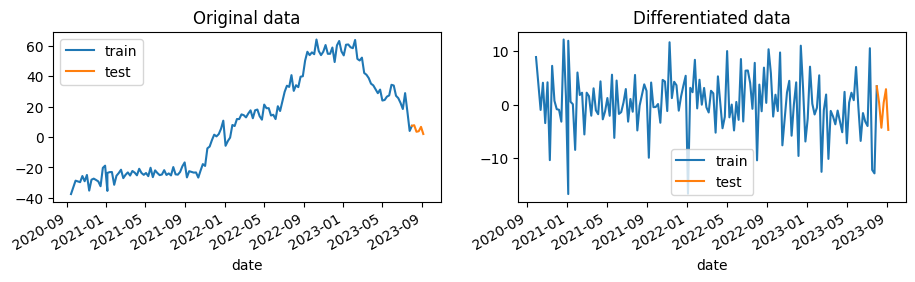

In [38]:
# Plot
# ==============================================================================
fig, axs = plt.subplots(1, 2, figsize=(11, 2.5))
axs = axs.ravel()
data.loc[:end_train].plot(ax=axs[0], label='train')
data.loc[end_train:].plot(ax=axs[0], label='test')
axs[0].legend()
axs[0].set_title('Original data')

data_diff.loc[:end_train].plot(ax=axs[1], label='train')
data_diff.loc[end_train:].plot(ax=axs[1], label='test')
axs[1].legend()
axs[1].set_title('Differentiated data');

In [39]:
data.loc[end_train:]

date
2023-07-31    7.458214
2023-08-07    7.832750
2023-08-14    3.525113
2023-08-21    3.896402
2023-08-28    6.754483
2023-09-04    2.053265
Name: wPreis, dtype: float64

In [40]:
data[-6:]

date
2023-07-31    7.458214
2023-08-07    7.832750
2023-08-14    3.525113
2023-08-21    3.896402
2023-08-28    6.754483
2023-09-04    2.053265
Name: wPreis, dtype: float64

In [44]:
data[:-6]

date
2020-09-14   -37.519318
2020-09-28   -28.690096
2020-10-12   -29.688079
2020-10-19   -25.630433
2020-10-26   -29.073794
                ...    
2023-06-26    22.501691
2023-07-03    18.514178
2023-07-10    28.985554
2023-07-17    16.847234
2023-07-24     4.063304
Name: wPreis, Length: 148, dtype: float64

In [41]:
# Forecasting without differentiation

steps = len(data[-6:])

# Forecasters
forecaster_dt = ForecasterAutoreg(
                    # Add the sklearn regressor and lags
                    regressor = DecisionTreeRegressor(random_state = 963),
                    lags = 4
                )

forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=963),
                    lags      = 4
                )
forecaster_gb = ForecasterAutoreg(
                    regressor = XGBRegressor(random_state=963),
                    lags      = 4
                )

In [45]:
# Train
forecaster_dt.fit(data[:-6])
forecaster_rf.fit(data[:-6])
forecaster_gb.fit(data[:-6])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/l

In [46]:
# Predict
predictions_dt = forecaster_dt.predict(steps=steps)
predictions_rf = forecaster_rf.predict(steps=steps)
predictions_gb = forecaster_gb.predict(steps=steps)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [51]:
# Predict
predictions_dt.index = data[-6:].index
predictions_rf.index = data[-6:].index
predictions_gb.index = data[-6:].index

In [47]:
# Error
error_dt = mean_absolute_error(data[-6:], predictions_dt)
error_rf = mean_absolute_error(data[-6:], predictions_rf)
error_gb = mean_absolute_error(data[-6:], predictions_gb)
print(f"Error (MAE) Decision Tree: {error_dt:.2f}")
print(f"Error (MAE) Random Forest: {error_rf:.2f}")
print(f"Error (MAE) Gradient Boosting: {error_gb:.2f}")

Error (MAE) Decision Tree: 6.99
Error (MAE) Random Forest: 9.28
Error (MAE) Gradient Boosting: 5.22


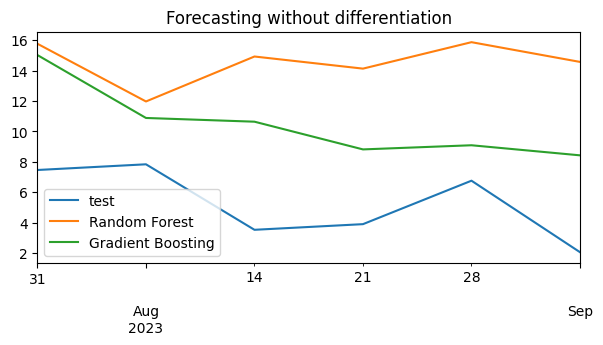

In [53]:


# Plot
fig, ax = plt.subplots(figsize=(7, 3), sharex=True, sharey=True)
# data[:-6].plot(ax=ax, label='train')
data[-6:].plot(ax=ax, label='test')
#predictions_dt.plot(ax=ax, label='Decision Tree')
predictions_rf.plot(ax=ax, label='Random Forest')
predictions_gb.plot(ax=ax, label='Gradient Boosting')
ax.set_title(f'Forecasting without differentiation')
ax.set_xlabel('')
ax.legend();

In [55]:
# Forecasting with differentiation
# ==============================================================================

# Forecasters
forecaster_dt = ForecasterAutoreg(
                    # Add the sklearn regressor and lags
                    regressor = DecisionTreeRegressor(random_state = 963),
                    lags = 4,
                    differentiation = 1
                )

forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=963),
                    lags      = 4, 
                    differentiation = 1
                )
forecaster_gb = ForecasterAutoreg(
                    regressor = XGBRegressor(random_state=963),
                    lags      = 4,
                    differentiation = 1
                )

In [56]:
# Train
forecaster_dt.fit(data[:-6])
forecaster_rf.fit(data[:-6])
forecaster_gb.fit(data[:-6])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/l

In [57]:
# Predict
predictions_dt = forecaster_dt.predict(steps=steps)
predictions_rf = forecaster_rf.predict(steps=steps)
predictions_gb = forecaster_gb.predict(steps=steps)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [62]:
# Predict
predictions_dt.index = data[-6:].index
predictions_rf.index = data[-6:].index
predictions_gb.index = data[-6:].index

In [58]:
# Error
error_dt = mean_absolute_error(data[-6:], predictions_dt)
error_rf = mean_absolute_error(data[-6:], predictions_rf)
error_gb = mean_absolute_error(data[-6:], predictions_gb)
print(f"Error (MAE) Decision Tree: {error_dt:.2f}")
print(f"Error (MAE) Random Forest: {error_rf:.2f}")
print(f"Error (MAE) Gradient Boosting: {error_gb:.2f}")

Error (MAE) Decision Tree: 3.67
Error (MAE) Random Forest: 1.21
Error (MAE) Gradient Boosting: 2.17


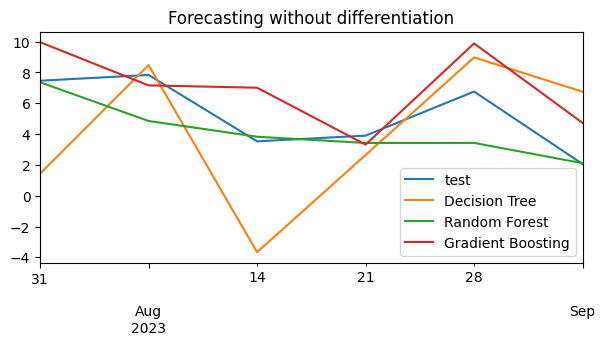

In [63]:


# Plot
fig, ax = plt.subplots(figsize=(7, 3), sharex=True, sharey=True)
# data[:-6].plot(ax=ax, label='train')
data[-6:].plot(ax=ax, label='test')
predictions_dt.plot(ax=ax, label='Decision Tree')
predictions_rf.plot(ax=ax, label='Random Forest')
predictions_gb.plot(ax=ax, label='Gradient Boosting')
ax.set_title(f'Forecasting without differentiation')
ax.set_xlabel('')
ax.legend();